# Лабораторная работа № 8. Оптимизация

## Повторение примеров

### 8.2.1. Линейное программирование

Линейное программирование рассматривает решения экстремальных задач на множествах 𝑛-мерного векторного пространства, задаваемых системами линейных уравнений
и неравенств.

Общей (стандартной) задачей линейного программирования называется задача нахождения минимума линейной целевой функции вида:
$$
f(\overrightarrow{x}) = \sum_{j=1}^{n} c_jx_j,
$$
где $\overrightarrow{c}$ — некоторые коэффициенты, $\overrightarrow{x} \in \mathbb{R}^n$.

Основной задачей линейного программирования называется задача, в которой есть
ограничения в форме неравенств:
$$
\sum_{j=1}^{n} a_{ij}x_j \geq b_i, \quad i = 1, 2, \dots, m, \quad x_j \geq 0, \quad j = 1, 2, \dots, n.
$$

Задачи линейного программирования со смешанными ограничениями, такими как
равенства и неравенства, с наличием переменных, свободных от ограничений, могут быть
сведены к эквивалентным с тем же множеством решений путём замены переменных
и замены равенств на пару неравенств.

В Julia есть несколько средств, предназначенных для решения оптимизационных задач.
Одним из таких средств является JuMP (https://jump.dev/) — язык моделирования
и вспомогательные пакеты для формулирования и решения задач математической оптимизации в Julia.

JuMP включает пакет `Convex.jl` (https://jump.dev/Convex.jl/stable/), позволяющий описать задачу оптимизации, используя естественный математический синтаксис,
и решать её с помощью одного из решателей (COSMO, ECOS, SCS, GLPK, MathOptInterface).

Предположим, что требуется решить следующую задачу линейного программирования:
$$
12x + 20y \rightarrow \min
$$
при заданных ограничениях:
$$
6x + 8y \geq 100, \quad 7x + 12y \geq 120, \quad x \geq 0, \quad y \geq 0.
$$


Воспользуемся JuMP и решателем линейного и смешанного целочисленного программирования GLPK:

In [1]:
# Подключение пакетов:
import Pkg
Pkg.add("JuMP")
Pkg.add("GLPK")

    Updating registry at `C:\Users\User\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\User\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\User\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\User\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\User\.julia\environments\v1.8\Manifest.toml`


In [2]:
using JuMP
using GLPK

Объект модели (контейнер для переменных, ограничений, параметров решателя и т. д.)
в JuMP создаётся при помощи функции Model(), в которой в качестве аргумента указывается оптимизатор (решатель):

In [3]:
# Определение объекта модели с именем model:
model = Model(GLPK.Optimizer)

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: GLPK

Переменные задаются с помощью конструкции `@variable` (имя объекта модели, имя
и привязка переменной, тип переменной). Здесь же задаются граничные условия на
переменные (если тип переменной не определён, он считается действительным):

In [4]:
# Определение переменных x, y и граничных условий для них:
@variable(model, x >= 0)
@variable(model, y >= 0)

y

В качестве первого аргумента указан объект модели model, затем переменные 𝑥 и 𝑦,
связанные с этой моделью (причём указанные переменные не могут использоваться
в другой модели).
Ограничения модели задаются с помощью конструкции `@constraint` (имя объекта
модели, ограничение):

In [5]:
# Определение ограничений модели:
@constraint(model, 6x + 8y >= 100)
@constraint(model, 7x + 12y >= 120)

7 x + 12 y >= 120

Далее следует задать собственно целевую функцию с помощью конструкции
`@objective` (имя объекта модели, Min или Max, функция для оптимизации):

In [6]:
# Определение целевой функции:
@objective(model, Min, 12x + 20y)

12 x + 20 y

Для решения задачи оптимизации необходимо вызывать функцию оптимизации:

In [7]:
# Вызов функции оптимизации:
optimize!(model)

Следует проверять причину прекращения работы оптимизатора, используя конструкцию termination_status(Объект модели):

In [8]:
# Определение причины завершения работы оптимизатора:
termination_status(model)

OPTIMAL::TerminationStatusCode = 1

Процесс решения мог быть прекращён по ряду причин. Во-первых, решатель мог
найти оптимальное решение или доказать, что проблема невозможна. Однако он также
мог столкнуться с численными трудностями или прерваться из-за таких настроек, как
ограничение по времени. Если возвращено значение OPTIMAL, найдено оптимальное
решение.
Наконец, можно посмотреть собственно результат решения оптимизационной задачи:

In [9]:
# Демонстрация первичных результирующих значений переменных x и y:
@show value(x);
@show value(y);

value(x) = 14.999999999999993
value(y) = 1.2500000000000047


In [10]:
# Демонстрация результата оптимизации:
@show objective_value(model);

objective_value(model) = 205.0


### 8.2.2. Векторизованные ограничения и целевая функция оптимизации

Часто бывает полезно создавать коллекции переменных JuMP внутри более сложных
структур данных. Можно добавить ограничения и цель в JuMP, используя векторизованную линейную алгебру.

Предположим, что требуется решить следующую задачу:
$$
\overrightarrow{c}^T \overrightarrow{x} \rightarrow \min
$$
при заданных ограничениях:
$$
A\overrightarrow{x} = \overrightarrow{b}, \quad \overrightarrow{x} \succeq 0, \quad \overrightarrow{x} \in \mathbb{R}^n,
$$
где

$$
A = \begin{pmatrix}
1 & 1 & 9 & 5 \\
3 & 5 & 0 & 8 \\
2 & 0 & 6 & 13
\end{pmatrix},
\overrightarrow{b} = \begin{pmatrix}
7 \\
3 \\
5
\end{pmatrix},
\overrightarrow{c} = \begin{pmatrix}
1 \\
3 \\
5 \\
2
\end{pmatrix}.
$$


Воспользуемся JuMP и решателем линейного и смешанного целочисленного программирования GLPK:

Определим объект модели:

In [11]:
# Определение объекта модели с именем vector_model:
vector_model = Model(GLPK.Optimizer)

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: GLPK

Зададим исходные значения матрицы $𝐴$ и векторов $\overrightarrow{b}$, $\overrightarrow{c}$:

In [12]:
# Определение начальных данных:
A= [ 1 1 9 5;
3 5 0 8;
2 0 6 13]

3×4 Matrix{Int64}:
 1  1  9   5
 3  5  0   8
 2  0  6  13

In [13]:
b = [7; 3; 5]

3-element Vector{Int64}:
 7
 3
 5

In [14]:
c = [1; 3; 5; 2]

4-element Vector{Int64}:
 1
 3
 5
 2

Далее зададим массив переменных для компонент вектора $\overrightarrow{x}$:

In [15]:
# Определение вектора переменных:
@variable(vector_model, x[1:4] >= 0)

4-element Vector{VariableRef}:
 x[1]
 x[2]
 x[3]
 x[4]

Затем зададим ограничения в соответствии с условиями модели:

In [16]:
# Определение ограничений модели:
@constraint(vector_model, A * x .== b)

3-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape}}:
 x[1] + x[2] + 9 x[3] + 5 x[4] == 7
 3 x[1] + 5 x[2] + 8 x[4] == 3
 2 x[1] + 6 x[3] + 13 x[4] == 5

Далее зададим целевую функцию:

In [17]:
# Определение целевой функции:
@objective(vector_model, Min, c' * x)

x[1] + 3 x[2] + 5 x[3] + 2 x[4]

Наконец, для решения задачи оптимизации вызовем функцию оптимизации:

In [18]:
# Вызов функции оптимизации:
optimize!(vector_model)

Проверим, что найдено оптимальное решение:

In [19]:
# Определение причины завершения работы оптимизатора:
termination_status(vector_model)

OPTIMAL::TerminationStatusCode = 1

Посмотрим результат решения оптимизационной задачи:

In [20]:
# Демонстрация результата оптимизации:
@show objective_value(vector_model);

objective_value(vector_model) = 4.9230769230769225


In [21]:
# Демонстрация первичных результирующих значений переменных x и y:
@show value.(x);

value.(x) = [0.4230769230769232, 0.34615384615384615, 0.6923076923076922, 0.0]


### 8.2.3. Оптимизация рациона питания

В некоторых задачах требуется использование массивов, в которых индексы не являются целыми диапазонами с отсчётом от единицы. Например, требуется использовать
переменную, индексируемую по названию продукта или местоположению. Тогда необходимо в качестве индекса использовать произвольный вектор. В Julia это можно
реализовать с помощью DenseAxisArrays.

Рассмотрим применение DenseAxisArrays на примере решения задачи оптимизации
рациона питании в заведении быстрого питания при условии, что задано ограничение
на количество потребляемых калорий (1800–2200), белков ($\geq 91$), жиров (0–65) и соли
(0–1779), а также перечень определённых продуктов питания с указанием их стоимости
— гамбургер (2.49 ден.ед.), курица (2.89 ден.ед.), сосиска в тесте (1.50 ден.ед.), жареный
картофель (1.89 ден.ед.), макароны (2.09 ден.ед.), пицца (1.99 ден.ед.), салат (2.49 ден.ед.),
молочный коктейль (0.89 ден.ед.), мороженное (1.59 ден.ед.). Также известно содержание
калорий, белков, жиров и соли в указанных продуктах.

                                                                Содержание калорий, белков, жиров и соли в продуктах питания
| продукт | калории | белки | жиры | соль |
|---------|---------|-------|------|------|
| гамбургер | 10 | 24 | 26 | 730 |
| курица | 420 | 32 | 10 | 1190 |
| сосиска в тесте | 560 | 20 | 32 | 1800 |
| жареный картофель | 380 | 4 | 19 | 270 |
| макароны | 320 | 12 | 10 | 930 |
| пицца | 320 | 15 | 12 | 820 |
| салат | 320 | 31 | 12 | 1230 |
| молочный коктейль | 100 | 8 | 2.5 | 125 |
| мороженное | 330 | 8 | 10 | 180 |

Воспользуемся JuMP и решателем линейного и смешанного целочисленного программирования GLPK :

Создадим контейнер JuMP для хранения информации об ограничениях (минимальное,
максимальное) на количество потребляемых калорий, белков, жиров и соли:

In [22]:
# Контейнер для хранения данных об ограничениях на количество потребляемых калорий, белков, жиров и соли:
category_data = JuMP.Containers.DenseAxisArray(
[1800 2200;
91 Inf;
0 65;
0 1779],
["calories", "protein", "fat", "sodium"],
["min", "max"])

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, ["calories", "protein", "fat", "sodium"]
    Dimension 2, ["min", "max"]
And data, a 4×2 Matrix{Float64}:
 1800.0  2200.0
   91.0    Inf
    0.0    65.0
    0.0  1779.0

Введём массив данных с наименованиями продуктов:

In [23]:
# массив данных с наименованиями продуктов:
foods = ["hamburger", "chicken", "hot dog", "fries", "macaroni", "pizza","salad", "milk", "ice cream"]

9-element Vector{String}:
 "hamburger"
 "chicken"
 "hot dog"
 "fries"
 "macaroni"
 "pizza"
 "salad"
 "milk"
 "ice cream"

Введём данные о стоимости продуктов:

In [24]:
# Массив стоимости продуктов:
cost = JuMP.Containers.DenseAxisArray(
[2.49, 2.89, 1.50, 1.89, 2.09, 1.99, 2.49, 0.89, 1.59],
foods)

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, ["hamburger", "chicken", "hot dog", "fries", "macaroni", "pizza", "salad", "milk", "ice cream"]
And data, a 9-element Vector{Float64}:
 2.49
 2.89
 1.5
 1.89
 2.09
 1.99
 2.49
 0.89
 1.59

Введём сведения о содержании калорий, белков, жиров и соли в продуктах питания:

In [25]:
# Массив данных о содержании калорий, белков, жиров и соли в продуктах питания:
food_data = JuMP.Containers.DenseAxisArray(
[410 24 26 730;
420 32 10 1190;
560 20 32 1800;
380 4 19 270;
320 12 10 930;
320 15 12 820;
320 31 12 1230;
100 8 2.5 125;
330 8 10 180],
foods,
["calories", "protein", "fat", "sodium"])

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, ["hamburger", "chicken", "hot dog", "fries", "macaroni", "pizza", "salad", "milk", "ice cream"]
    Dimension 2, ["calories", "protein", "fat", "sodium"]
And data, a 9×4 Matrix{Float64}:
 410.0  24.0  26.0   730.0
 420.0  32.0  10.0  1190.0
 560.0  20.0  32.0  1800.0
 380.0   4.0  19.0   270.0
 320.0  12.0  10.0   930.0
 320.0  15.0  12.0   820.0
 320.0  31.0  12.0  1230.0
 100.0   8.0   2.5   125.0
 330.0   8.0  10.0   180.0

Определим объект модели:

In [26]:
# Определение объекта модели с именем model:
model = Model(GLPK.Optimizer)

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: GLPK

Определим массив:

In [27]:
# Определим массив:
categories = ["calories", "protein", "fat", "sodium"]

4-element Vector{String}:
 "calories"
 "protein"
 "fat"
 "sodium"

Далее зададим переменные:

In [28]:
# Определение переменных:
@variables(model, begin
    category_data[c, "min"] <= nutrition[c = categories] <= category_data[c, "max"]
    # Сколько покупать продуктов:
    buy[foods] >= 0
end)

(1-dimensional DenseAxisArray{VariableRef,1,...} with index sets:
    Dimension 1, ["calories", "protein", "fat", "sodium"]
And data, a 4-element Vector{VariableRef}:
 nutrition[calories]
 nutrition[protein]
 nutrition[fat]
 nutrition[sodium], 1-dimensional DenseAxisArray{VariableRef,1,...} with index sets:
    Dimension 1, ["hamburger", "chicken", "hot dog", "fries", "macaroni", "pizza", "salad", "milk", "ice cream"]
And data, a 9-element Vector{VariableRef}:
 buy[hamburger]
 buy[chicken]
 buy[hot dog]
 buy[fries]
 buy[macaroni]
 buy[pizza]
 buy[salad]
 buy[milk]
 buy[ice cream])

Задаём целевую функцию минимизации цены:

In [29]:
# Определение целевой функции:
@objective(model, Min, sum(cost[f] * buy[f] for f in foods))

2.49 buy[hamburger] + 2.89 buy[chicken] + 1.5 buy[hot dog] + 1.89 buy[fries] + 2.09 buy[macaroni] + 1.99 buy[pizza] + 2.49 buy[salad] + 0.89 buy[milk] + 1.59 buy[ice cream]

Затем зададим ограничения в соответствии с условиями модели:

In [30]:
# Определение ограничений модели:
@constraint(model, [c in categories],
sum(food_data[f, c] * buy[f] for f in foods) == nutrition[c])

1-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape},1,...} with index sets:
    Dimension 1, ["calories", "protein", "fat", "sodium"]
And data, a 4-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape}}:
 -nutrition[calories] + 410 buy[hamburger] + 420 buy[chicken] + 560 buy[hot dog] + 380 buy[fries] + 320 buy[macaroni] + 320 buy[pizza] + 320 buy[salad] + 100 buy[milk] + 330 buy[ice cream] == 0
 -nutrition[protein] + 24 buy[hamburger] + 32 buy[chicken] + 20 buy[hot dog] + 4 buy[fries] + 12 buy[macaroni] + 15 buy[pizza] + 31 buy[salad] + 8 buy[milk] + 8 buy[ice cream] == 0
 -nutrition[fat] + 26 buy[hamburger] + 10 buy[chicken] + 32 buy[hot dog] + 19 buy[fries] + 10 buy[macaroni] + 12 buy[pizza] + 12 buy[salad] + 2.5 buy[milk] + 10 buy[ice cream] == 0


Наконец, для решения задачи оптимизации вызовем функцию оптимизации:

In [31]:
# Вызов функции оптимизации:
JuMP.optimize!(model)
term_status = JuMP.termination_status(model)

OPTIMAL::TerminationStatusCode = 1

Для просмотра результата решения модно вывести значение переменной buy:

In [32]:
hcat(buy.data, JuMP.value.(buy.data))

9×2 Matrix{AffExpr}:
 buy[hamburger]  0.6045138888888888
 buy[chicken]    0
 buy[hot dog]    0
 buy[fries]      0
 buy[macaroni]   0
 buy[pizza]      0
 buy[salad]      0
 buy[milk]       6.9701388888888935
 buy[ice cream]  2.591319444444441

В результате оптимальным по цене и пищевой ценности будет предложено купить
гамбургер, молочный коктейль и мороженное.

### 8.2.4. Путешествие по миру

Рассмотрим решение задачи определения оптимального числа паспортов, требующихся, чтобы объехать весь мир. При этом будем учитывать сведения о паспортах
и ограничениях, указанных на ресурсе https://www.passportindex.org/. В табличной форме данные можно получить с ресурса https://github.com/ilyankou/passport-index-dataset. Для решения задачи представляют интерес данные, указанные в файле passport-index-matrix.csv, в котором в первым столбце (Passport) указана страна отбытия (= от), в остальных столбцах указаны страны назначения (= до), на пересечении строк и столбцов указаны условия по наличию или отсутствию визы или другие ограничения (обозначения пояснены в таблице)

                                                                Обозначения в сводной матрице по паспортам
| Значение | Пояснение |
|----------|-----------|
| 7–360 | Количество безвизовых дней (при наличии) |
| VF | viza free (безвизовый режим) |
| VOA | visa on arriva (виза по прибытии) |
| ETA | e-visa или electronic travel authority (электронная виза) |
| VR | visa required (требуется виза) |
| covid ban | запрет в связи с COVID-19 |
| no admission | въезд запрещён |
| -1 | паспорт из места назначения |

Итак, попробуем решить задачу средствами Julia.

Сначала требуется скачать файл с данными. Например для ОС типа Linux можно воспользоваться стандартным вызовом команды git с соответствующими параметрами:

In [33]:
# Скачиваем данные с ресурса на git:
;git clone https://github.com/ilyankou/passport-index-dataset.git

LoadError: syntax: extra token "clone" after end of expression

Затем требуется подключить пакеты для обработки табличных файлов:

In [34]:
# Подключение пакетов:
import Pkg
Pkg.add("DelimitedFiles")
Pkg.add("CSV")

   Resolving package versions...
  No Changes to `C:\Users\User\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\User\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\User\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\User\.julia\environments\v1.8\Manifest.toml`


In [35]:
using DelimitedFiles
using CSV

Можем считать данные из имеющегося файла:

In [36]:
# Считывание данных:
passportdata = readdlm("passport-index-matrix.csv",',')

200×200 Matrix{Any}:
 "Passport"                "Albania"        …    "Afghanistan"
 "Afghanistan"             "visa required"     -1
 "Albania"               -1                      "visa required"
 "Algeria"                 "visa required"       "visa required"
 "Andorra"               90                      "visa required"
 "Angola"                  "visa required"  …    "visa required"
 "Antigua and Barbuda"   90                      "visa required"
 "Argentina"             90                      "visa required"
 "Armenia"               90                      "visa required"
 "Australia"             90                      "visa required"
 "Austria"               90                 …    "visa required"
 "Azerbaijan"            90                      "visa required"
 "Bahamas"               90                      "visa required"
 ⋮                                          ⋱  
 "United Arab Emirates"  90                      "visa required"
 "United Kingdom"        90           

Далее просматриваем файл, задаём переменную для подсчёта числа паспортов, задаём
переменную vf, в которую заносим сведения при отсутствии необходимости получать
визу (если в поле указано число, «VF» или «VOA»):

In [37]:
# Задаём переменные:
cntr = passportdata[2:end,1]

199-element Vector{Any}:
 "Afghanistan"
 "Albania"
 "Algeria"
 "Andorra"
 "Angola"
 "Antigua and Barbuda"
 "Argentina"
 "Armenia"
 "Australia"
 "Austria"
 "Azerbaijan"
 "Bahamas"
 "Bahrain"
 ⋮
 "United Arab Emirates"
 "United Kingdom"
 "United States"
 "Uruguay"
 "Uzbekistan"
 "Vanuatu"
 "Vatican"
 "Venezuela"
 "Vietnam"
 "Yemen"
 "Zambia"
 "Zimbabwe"

In [38]:
vf = (x -> typeof(x) == Int64 || x == "VF" || x == "VOA" ? 1 : 0).(passportdata[2:end,2:end]);

Определяем объект модели:

In [39]:
# Определение объекта модели с именем model:
model = Model(GLPK.Optimizer)

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: GLPK

Добавляем переменные, ограничения и целевую функцию:

In [40]:
# Переменные, ограничения и целевая функция:
@variable(model, pass[1:length(cntr)], Bin)

199-element Vector{VariableRef}:
 pass[1]
 pass[2]
 pass[3]
 pass[4]
 pass[5]
 pass[6]
 pass[7]
 pass[8]
 pass[9]
 pass[10]
 pass[11]
 pass[12]
 pass[13]
 ⋮
 pass[188]
 pass[189]
 pass[190]
 pass[191]
 pass[192]
 pass[193]
 pass[194]
 pass[195]
 pass[196]
 pass[197]
 pass[198]
 pass[199]

In [41]:
@constraint(model, [j=1:length(cntr)], sum(vf[i,j]*pass[i] for i in 1:length(cntr)) >= 1)

199-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.GreaterThan{Float64}}, ScalarShape}}:
 pass[2] + pass[4] + pass[6] + pass[7] + pass[8] + pass[9] + pass[10] + pass[11] + pass[12] + pass[13] + pass[15] + pass[16] + pass[17] + pass[22] + pass[24] + pass[25] + pass[26] + pass[31] + pass[35] + pass[36] + pass[37] + pass[41] + pass[43] + pass[45] + pass[46] + pass[47] + pass[53] + pass[56] + pass[60] + pass[61] + pass[64] + pass[65] + pass[67] + pass[69] + pass[74] + pass[75] + pass[76] + pass[77] + pass[82] + pass[83] + pass[84] + pass[86] + pass[88] + pass[91] + pass[92] + pass[95] + pass[100] + pass[101] + pass[102] + pass[103] + pass[106] + pass[109] + pass[112] + pass[113] + pass[115] + pass[116] + pass[118] + pass[125] + pass[126] + pass[127] + pass[131] + pass[132] + pass[133] + pass[137] + pass[139] + pass[140] + pass[142] + pass[143] + pass[144] + pass[145] + pass[146] + pass[148] + pass[151] +

In [42]:
@objective(model, Min, sum(pass))

pass[1] + pass[2] + pass[3] + pass[4] + pass[5] + pass[6] + pass[7] + pass[8] + pass[9] + pass[10] + pass[11] + pass[12] + pass[13] + pass[14] + pass[15] + pass[16] + pass[17] + pass[18] + pass[19] + pass[20] + pass[21] + pass[22] + pass[23] + pass[24] + pass[25] + pass[26] + pass[27] + pass[28] + pass[29] + pass[30] + pass[31] + pass[32] + pass[33] + pass[34] + pass[35] + pass[36] + pass[37] + pass[38] + pass[39] + pass[40] + pass[41] + pass[42] + pass[43] + pass[44] + pass[45] + pass[46] + pass[47] + pass[48] + pass[49] + pass[50] + pass[51] + pass[52] + pass[53] + pass[54] + pass[55] + pass[56] + pass[57] + pass[58] + pass[59] + pass[60] + pass[61] + pass[62] + pass[63] + pass[64] + pass[65] + pass[66] + pass[67] + pass[68] + pass[69] + pass[70] + pass[71] + pass[72] + pass[73] + pass[74] + pass[75] + pass[76] + pass[77] + pass[78] + pass[79] + pass[80] + pass[81] + pass[82] + pass[83] + pass[84] + pass[85] + pass[86] + pass[87] + pass[88] + pass[89] + pass[90] + pass[91] + pass[92]

Для решения задачи оптимизации вызываем функцию оптимизации:

In [43]:
# Вызов функции оптимизации:
JuMP.optimize!(model)
termination_status(model)

OPTIMAL::TerminationStatusCode = 1

Просматриваем результат:

In [44]:
# Просмотр результата:
print(JuMP.objective_value(model)," passports: ",join(cntr[findall(JuMP.value.(pass) .== 1)],", "))

63.0 passports: Afghanistan, Andorra, Argentina, Australia, Azerbaijan, Bahrain, Brunei, Cambodia, Cameroon, Canada, Chile, Colombia, Comoros, DR Congo, Djibouti, Equatorial Guinea, Eritrea, Fiji, Gabon, Georgia, Guinea, Guinea-Bissau, Hong Kong, Hungary, Indonesia, Iraq, Ireland, Israel, Jamaica, Japan, Kuwait, Laos, Liberia, Libya, Macao, Madagascar, Malaysia, Maldives, Marshall Islands, Mauritania, Mauritius, Mongolia, Mozambique, Nauru, Nepal, New Zealand, North Korea, Palestine, Papua New Guinea, Qatar, Saudi Arabia, Solomon Islands, Somalia, South Sudan, Sri Lanka, Syria, Taiwan, Timor-Leste, Togo, Turkmenistan, United States, Uruguay, Vietnam

### 8.2.5. Портфельные инвестиции

Портфельные инвестиции — размещение капитала в ценные бумаги, формируемые
в виде портфеля ценных бумаг, с целью получения прибыли.

Инвестиционный портфель — процесс стратегического управления капиталом как
оптимизированной, единой системой инвестиционных ценностей.

Предположим требуется решить оптимизационную задачу в следующей формулировке.
Имеется капитал в 1000 ден. ед., который планируется инвестировать в три компании —
Microsoft, Facebook, Apple. При этом есть данные еженедельных значений цен на акции
этих компаний за определённый период времени. Необходимо определить доходность
акций каждой компании за рассматриваемый период времени, после чего инвестировать
в эти три компании так, чтобы получить возврат в размере не менее 2% от вложенной
суммы.

Для решения оптимизационной задачи будем использовать пакет `Convex.jl` и оптимизатор (решатель) SCS. Кроме того, понадобится пакет `Statistics.jl` для получения
матрицы рисков на основе расчёта ковариационных значений по доходности.

Сначала требуется подгрузить имеющиеся данные о еженедельных значениях цен
на акции рассматриваемых компаний, отобразить данные на графике. Предположим
данные размещены в файле stock_prices.xlsx в каталоге data в проекте.

Подключаем пакеты:

In [45]:
# Подключение необходимых пакетов:
import Pkg
Pkg.add("DataFrames")
Pkg.add("XLSX")
Pkg.add("Plots")
Pkg.add("PyPlot")
Pkg.add("Convex")
Pkg.add("SCS")
Pkg.add("Statistics")

   Resolving package versions...
  No Changes to `C:\Users\User\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\User\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\User\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\User\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\User\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\User\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\User\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\User\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\User\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\User\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\User\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\U

In [46]:
using DataFrames
using XLSX
using Plots

In [47]:
pyplot()

Plots.PyPlotBackend()

In [48]:
using Convex
using SCS
using Statistics

Подгружаем данные еженедельных значений цен на акции компаний за определённый
период времени во фрейм:

In [49]:
T = DataFrame(XLSX.readtable("stock_prices.xlsx","Sheet2"))

Row,MSFT,FB,AAPL
,Any,Any,Any
1,101.93,137.95,148.26
2,102.8,143.8,152.29
3,107.71,150.04,156.82
4,107.17,149.01,157.76
5,102.78,165.71,166.52
6,105.67,167.33,170.41
7,108.22,162.5,170.42
8,110.97,161.89,172.97
9,112.53,162.28,174.97


Отображаем данные на графике:

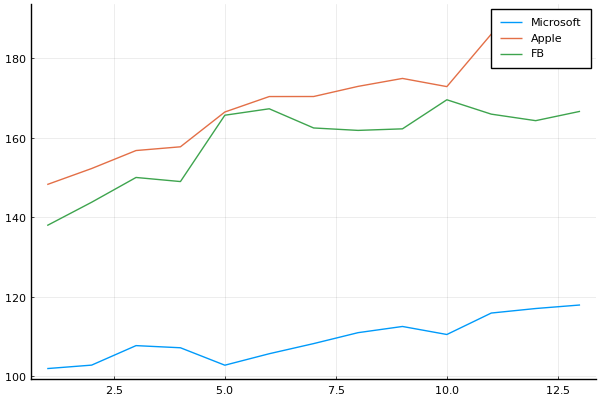

In [50]:
# Построение графика:
plot(T[!,:MSFT],label="Microsoft")
plot!(T[!,:AAPL],label="Apple")
plot!(T[!,:FB],label="FB")

Для дальнейших расчётов данные по ценам на акции переформируем из фрейма
в матрицу:

In [51]:
# Данные о ценах на акции размещаем в матрице:
prices_matrix = Matrix(T)

13×3 Matrix{Any}:
 101.93  137.95  148.26
 102.8   143.8   152.29
 107.71  150.04  156.82
 107.17  149.01  157.76
 102.78  165.71  166.52
 105.67  167.33  170.41
 108.22  162.5   170.42
 110.97  161.89  172.97
 112.53  162.28  174.97
 110.51  169.6   172.91
 115.91  165.98  186.12
 117.05  164.34  191.05
 117.94  166.69  189.95

Доходность акций 𝑖-й компании за период времени $𝑡$ определяется формулой:
$𝑅(𝑖, 𝑡) = \frac{\mathrm{pr}(𝑖, 𝑡) − \mathrm{pr}(𝑖, 𝑡 − 1))}{\mathrm{pr}(𝑖, 𝑡 − 1)}$, где $\mathrm{pr}(𝑖, 𝑡)$ — цена акций 𝑖-й компании за
период времени $𝑡$:

In [52]:
# Вычисление матрицы доходности за период времени:
M1 = prices_matrix[1:end-1,:]

12×3 Matrix{Any}:
 101.93  137.95  148.26
 102.8   143.8   152.29
 107.71  150.04  156.82
 107.17  149.01  157.76
 102.78  165.71  166.52
 105.67  167.33  170.41
 108.22  162.5   170.42
 110.97  161.89  172.97
 112.53  162.28  174.97
 110.51  169.6   172.91
 115.91  165.98  186.12
 117.05  164.34  191.05

In [53]:
M2 = prices_matrix[2:end,:]

12×3 Matrix{Any}:
 102.8   143.8   152.29
 107.71  150.04  156.82
 107.17  149.01  157.76
 102.78  165.71  166.52
 105.67  167.33  170.41
 108.22  162.5   170.42
 110.97  161.89  172.97
 112.53  162.28  174.97
 110.51  169.6   172.91
 115.91  165.98  186.12
 117.05  164.34  191.05
 117.94  166.69  189.95

In [54]:
# Матрица доходности:
R = (M2.-M1)./M1

12×3 Matrix{Float64}:
  0.00853527   0.0424067    0.027182
  0.0477626    0.0433936    0.0297459
 -0.00501346  -0.00686484   0.00599413
 -0.040963     0.112073     0.0555274
  0.0281183    0.00977611   0.0233606
  0.0241317   -0.0288651    5.8682e-5
  0.0254112   -0.00375385   0.014963
  0.0140579    0.00240904   0.0115627
 -0.0179508    0.0451072   -0.0117734
  0.0488644   -0.0213443    0.0763981
  0.00983522  -0.00988071   0.0264883
  0.00760359   0.0142996   -0.00575766

Далее необходимо сформировать матрицу рисков — ковариационную матрицу рассчитанных цен доходности:

In [55]:
# Матрица рисков:
risk_matrix = cov(R)

3×3 Matrix{Float64}:
  0.000659383  -0.000630653  0.000139112
 -0.000630653   0.00152162   0.000192288
  0.000139112   0.000192288  0.000635503

In [56]:
# Проверка положительной определённости матрицы рисков:
isposdef(risk_matrix)

true

Доход от каждой из компаний получим из матрицы доходности как вектор средних
значений:

In [57]:
# Доход от каждой из компаний:
r = mean(R,dims=1)[:]

3-element Vector{Float64}:
 0.012532748705136572
 0.016563036855293173
 0.02114580465503291

Далее нужно собственно сформулировать оптимизационную задачу. Пусть вектор $\overrightarrow{x} = (x_1, x_2, x_3)$ — вектор инвестиций, вектор $\overrightarrow{r} = (r_1, r_2, r_3)$ — вектор доходов от
компаний. Тогда задача оптимизации будет иметь вид:
$$
\overrightarrow{x}^T \mathrm{cov}(R) \overrightarrow{x} \rightarrow \min
$$
при условии:
$$
\sum_{i=1}^{3} x_i = 1, \quad \mathrm{dot}(\overrightarrow{r}, \overrightarrow{x}) \geq 0.02, \quad x_i \geq 0, i = 1, 2, 3,
$$
где $\mathrm{dot}(\overrightarrow{r}, \overrightarrow{x})$ — функция, определяющая возврат инвестиций.

Формируем вектор инвестиций:

In [58]:
# Вектор инвестиций:
x = Variable(length(r))

Variable
size: (3, 1)
sign: real
vexity: affine
id: 173…662

Определяем объект модели в соответствии с формулировкой оптимизационной задачи (при этом делаем задачу совместимой с DCP в соответствии с требованием пакета
`Convex.jl` — см. http://cvxr.com/cvx/doc/dcp.html):

In [59]:
# Объект модели:
problem = minimize(Convex.quadform(x,risk_matrix),[sum(x)==1; r'*x >= 0.02; x.>=0])

minimize
└─ * (convex; positive)
   ├─ 1
   └─ qol_elem (convex; positive)
      ├─ norm2 (convex; positive)
      │  └─ …
      └─ [1.0;;]
subject to
├─ == constraint (affine)
│  ├─ sum (affine; real)
│  │  └─ 3-element real variable (id: 173…662)
│  └─ 1
├─ >= constraint (affine)
│  ├─ * (affine; real)
│  │  ├─ [0.0125327 0.016563 0.0211458]
│  │  └─ 3-element real variable (id: 173…662)
│  └─ 0.02
├─ >= constraint (affine)
│  ├─ index (affine; real)
│  │  └─ 3-element real variable (id: 173…662)
│  └─ 0
├─ >= constraint (affine)
│  ├─ index (affine; real)
│  │  └─ 3-element real variable (id: 173…662)
│  └─ 0
└─ >= constraint (affine)
   ├─ index (affine; real)
   │  └─ 3-element real variable (id: 173…662)
   └─ 0

status: `solve!` not called yet

Решаем поставленную задачу:

In [60]:
# Находим решение:
solve!(problem, SCS.Optimizer)

------------------------------------------------------------------
	       SCS v3.2.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 6, constraints m: 14
cones: 	  z: primal zero / dual free vars: 2
	  l: linear vars: 5
	  q: soc vars: 7, qsize: 2
settings: eps_abs: 1.0e-004, eps_rel: 1.0e-004, eps_infeas: 1.0e-007
	  alpha: 1.50, scale: 1.00e-001, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-006
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 24, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0|1.71e+001 1.00e+000 1.62e+001 -8.03e+000 1.00e-001 3.99e-003 
    75|8.16e-005 1.46e-004 5.60e-005 5.56e-004 1.00e-001 4.03e-003 
------

Выводим значения компонент вектора инвестиций:

In [61]:
x

Variable
size: (3, 1)
sign: real
vexity: affine
id: 173…662
value: [0.06922834751660402, 0.117301582202275, 0.8134695146542507]

Проверяем выполнение условия $\sum\limits_{i=1}^{3} x_i = 1$:

In [62]:
sum(x.value)

0.9999994443731297

Проверяем выполнение условия на уровень доходности от 2%:

In [63]:
r'*x.value

1×1 adjoint(::Vector{Float64}) with eltype Float64:
 0.02001195936160116

Переводим процентные значения компонент вектора инвестиций в фактические денежные единицы:

In [64]:
x.value .* 1000

3×1 Matrix{Float64}:
  69.22834751660402
 117.301582202275
 813.4695146542507

В результате, получаем: надо инвестировать 69.2 ден. ед. в Microsoft, 117.3 ден. ед.
в Facebook, 813.5 ден. ед. в Apple.

### 8.2.6. Восстановление изображения

Предположим есть изображение, на котором были изменены некоторые пиксели. Требуется восстановить неизвестные пиксели путём решения задачи оптимизации.

Будем использовать пакет `Convex.jl` и оптимизатор (решатель) SCS, пакет
`ImageMagick.jl` для работы с изображениями:

In [65]:
# Подключение необходимых пакетов:
import Pkg
Pkg.add("ImageMagick")
Pkg.add("Convex")
Pkg.add("SCS")

   Resolving package versions...
  No Changes to `C:\Users\User\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\User\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\User\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\User\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\User\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\User\.julia\environments\v1.8\Manifest.toml`


In [66]:
using ImageMagick
using Images
using Convex
using SCS

Загрузим изображение для последующей обработки:

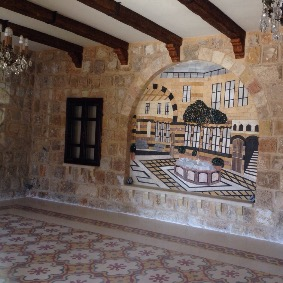

In [67]:
# Считывание исходного изображения:
Kref = load("khiam-small.jpg")

Преобразуем изображение в оттенки серого и испортим некоторые пиксели:

In [68]:
K = copy(Kref)
p = prod(size(K))

80089

In [69]:
missingids = rand(1:p, 400)

400-element Vector{Int64}:
 54712
 55301
 54582
 76938
 59942
 20402
 54613
 58801
 37017
 70846
 31552
 57677
  2590
     ⋮
 35139
  1925
 69691
 68889
 34489
 46789
 28696
 51079
 59608
 61127
 38939
 70348

In [70]:
K[missingids] .= RGBX{N0f8}(0.0,0.0,0.0)

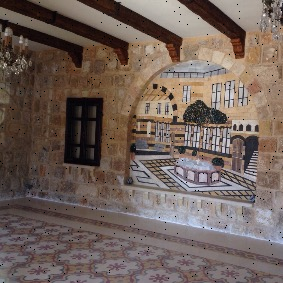

In [71]:
K

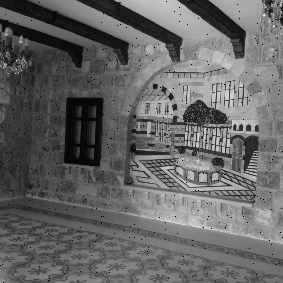

In [72]:
Gray.(K)

Формируем матрицу со значениями цветов:

In [73]:
# Матрица цветов:
Y = Float64.(Gray.(K))

283×283 Matrix{Float64}:
 0.101961   0.0627451  0.0784314  0.0941176  …  0.509804  0.552941  0.666667
 0.0666667  0.0980392  0.0745098  0.054902      0.505882  0.584314  0.501961
 0.0784314  0.0862745  0.0784314  0.0901961     0.6       0.701961  0.615686
 0.0862745  0.0666667  0.0745098  0.0941176     0.658824  0.705882  0.145098
 0.0784314  0.101961   0.0901961  0.0745098     0.713725  0.682353  0.231373
 0.0745098  0.0745098  0.0784314  0.0862745  …  0.729412  0.701961  0.168627
 0.12549    0.0980392  0.0862745  0.0862745     0.627451  0.466667  0.192157
 0.439216   0.447059   0.305882   0.137255      0.231373  0.184314  0.137255
 0.458824   0.454902   0.45098    0.454902      0.196078  0.101961  0.117647
 0.45098    0.466667   0.458824   0.45098       0.584314  0.121569  0.137255
 0.458824   0.458824   0.458824   0.454902   …  0.521569  0.0       0.12549
 0.466667   0.45098    0.458824   0.47451       0.576471  0.741176  0.117647
 0.45098    0.45098    0.462745   0.458824      0.56

Далее необходимо сформировать новую матрицу 𝑋, в которой минимизируется норма
ядра матрицы (т.е. сумма сингулярных чисел элементов матрицы) так, что элементы,
которые уже известны в матрице 𝑌, остаются теми же самыми в матрице 𝑋:

In [74]:
correctids = findall(Y[:].!=0)

79689-element Vector{Int64}:
     1
     2
     3
     4
     5
     6
     7
     8
     9
    10
    11
    12
    13
     ⋮
 80078
 80079
 80080
 80081
 80082
 80083
 80084
 80085
 80086
 80087
 80088
 80089

In [75]:
X = Convex.Variable(size(Y))

Variable
size: (283, 283)
sign: real
vexity: affine
id: 937…106

In [76]:
problem = minimize(nuclearnorm(X))

minimize
└─ nuclearnorm (convex; positive)
   └─ 283×283 real variable (id: 937…106)

status: `solve!` not called yet

In [77]:
problem.constraints += X[correctids]==Y[correctids]

1-element Vector{Constraint}:
 == constraint (affine)
├─ index (affine; real)
│  └─ 283×283 real variable (id: 937…106)
└─ 79689-element Vector{Float64}

Решаем поставленную задачу:

In [78]:
# Находим решение:
solve!(problem, SCS.Optimizer())

------------------------------------------------------------------
	       SCS v3.2.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 240268, constraints m: 400046
cones: 	  z: primal zero / dual free vars: 239585
	  s: psd vars: 160461, ssize: 1
settings: eps_abs: 1.0e-004, eps_rel: 1.0e-004, eps_infeas: 1.0e-007
	  alpha: 1.50, scale: 1.00e-001, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-006
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 400329, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0|1.50e+001 9.96e-001 8.34e+003 1.77e+002 1.00e-001 7.03e-001 
   250|8.26e-004 4.23e-005 1.69e-005 4.46e+002 3.39e-001 7.19e+001 
   37

Выводим значение нормы и исправленное изображение:

In [79]:
@show norm(float.(Gray.(Kref))-X.value)
@show norm(-X.value)

norm(float.(Gray.(Kref)) - X.value) = 1.1972000383851917
norm(-(X.value)) = 124.3381331081336


124.3381331081336

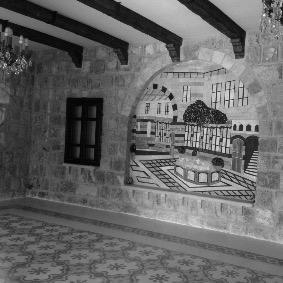

In [80]:
colorview(Gray, X.value)

## Самостоятельного задание

### 8.4.1. Линейное программирование

Решите задачу линейного программирования:
$$
x_1 + 2x_2 + 5x_3 \rightarrow \max,
$$
при заданных ограничениях:
$$
-x_1 + x_2 + 3x_3 \leq -5, \quad x_1 + 3x_2 - 7x_3 \leq 10, \quad 0 \leq x_1 \leq 10, \quad x_2 \geq 0, \quad x_3 \geq 0.
$$

In [81]:
model = Model(GLPK.Optimizer)

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: GLPK

In [82]:
# Определение переменных x, y, z и граничных условий для них:
@variable(model, x >= 0)
@variable(model, y >= 0)
@variable(model, z >= 0)

z

In [83]:
# Определение ограничений модели:
@constraint(model, -x + y + 3z <= -5)
@constraint(model, x + 3y - 7z <= 10)
@constraint(model, x <= 10)

x <= 10

In [84]:
# Определение целевой функции:
@objective(model, Max, x + 2y + 5z)

x + 2 y + 5 z

In [85]:
# Вызов функции оптимизации:
optimize!(model)

In [86]:
# Определение причины завершения работы оптимизатора:
termination_status(model)

OPTIMAL::TerminationStatusCode = 1

In [87]:
# Демонстрация первичных результирующих значений переменных x и y:
@show value(x);
@show value(y);
@show value(z);

value(x) = 10.0
value(y) = 2.1875
value(z) = 0.9375


In [88]:
# Демонстрация результата оптимизации:
@show objective_value(model);

objective_value(model) = 19.0625


### 8.4.2. Линейное программирование. Использование массивов

Решите предыдущее задание, используя массивы вместо скалярных переменных.

Рекомендация. Запишите систему ограничений в виде $𝐴\overrightarrow{x} = \overrightarrow{b}$, а целевую функцию как $\overrightarrow{c}^T \overrightarrow{x}$.

In [89]:
# Определение объекта модели с именем vector_model:
vector_model = Model(GLPK.Optimizer)

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: GLPK

In [90]:
# Определение начальных данных:
A= [-1 1 3;
    1 3 -7;
    1 0 0]

3×3 Matrix{Int64}:
 -1  1   3
  1  3  -7
  1  0   0

In [91]:
b = [-5; 10; 10]

3-element Vector{Int64}:
 -5
 10
 10

In [92]:
c = [1; 2; 5]

3-element Vector{Int64}:
 1
 2
 5

In [93]:
# Определение вектора переменных:
@variable(vector_model, x[1:3] >= 0)

3-element Vector{VariableRef}:
 x[1]
 x[2]
 x[3]

In [94]:
# Определение ограничений модели:
@constraint(vector_model, A * x .<= b)

3-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape}}:
 -x[1] + x[2] + 3 x[3] <= -5
 x[1] + 3 x[2] - 7 x[3] <= 10
 x[1] <= 10

In [95]:
# Определение целевой функции:
@objective(vector_model, Max, c' * x)

x[1] + 2 x[2] + 5 x[3]

In [96]:
# Вызов функции оптимизации:
optimize!(vector_model)

In [97]:
# Определение причины завершения работы оптимизатора:
termination_status(vector_model)

OPTIMAL::TerminationStatusCode = 1

In [98]:
@show value.(x);

value.(x) = [10.0, 2.1875, 0.9375]


In [99]:
# Демонстрация результата оптимизации:
@show objective_value(vector_model);

objective_value(vector_model) = 19.0625


Результаты совпали

### 8.4.3. Выпуклое программирование

Решите задачу оптимизации:
$$
\big|\big|A\overrightarrow{x} - \overrightarrow{b}\big|\big|^2_2 \rightarrow \min
$$
при заданных ограничениях:
$$
\overrightarrow{x} \succeq 0,
$$
где $\overrightarrow{x} \in \mathbb{R}^n$, $A \in \mathbb{R}^{m \times n}$, $\overrightarrow{b} \in \mathbb{R}^m $.

Матрицу $A$ и вектор $\overrightarrow{b}$ задайте случайным образом.

Для решения задачи используйте пакет Convex и решатель SCS.

In [100]:
# Начальные данные
n = 5
m = 3
A = rand(m, n)

3×5 Matrix{Float64}:
 0.195653  0.27741    0.492483   0.832163  0.669575
 0.193799  0.0767969  0.0730974  0.610976  0.142437
 0.904045  0.159921   0.475515   0.531075  0.652775

In [101]:
b = rand(m)

3-element Vector{Float64}:
 0.23576053235825278
 0.6008013249733486
 0.1268187172969143

In [102]:
x = Variable(n)

Variable
size: (5, 1)
sign: real
vexity: affine
id: 400…912

In [103]:
I = zeros(m, m)
for i ∈ 1:m
    I[i, i] = 1
end
I

3×3 Matrix{Float64}:
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

In [104]:
Y = A*x - b

+ (affine; real)
├─ * (affine; real)
│  ├─ 3×5 Matrix{Float64}
│  └─ 5-element real variable (id: 400…912)
└─ [-0.235761, -0.600801, -0.126819]

In [105]:
problem3 = minimize(Convex.quadform(Y, I))

minimize
└─ * (convex; positive)
   ├─ 1
   └─ qol_elem (convex; positive)
      ├─ norm2 (convex; positive)
      │  └─ …
      └─ [1.0;;]

status: `solve!` not called yet

In [106]:
problem3.constraints += x .>= 0

5-element Vector{Constraint}:
 >= constraint (affine)
├─ index (affine; real)
│  └─ 5-element real variable (id: 400…912)
└─ 0
 >= constraint (affine)
├─ index (affine; real)
│  └─ 5-element real variable (id: 400…912)
└─ 0
 >= constraint (affine)
├─ index (affine; real)
│  └─ 5-element real variable (id: 400…912)
└─ 0
 >= constraint (affine)
├─ index (affine; real)
│  └─ 5-element real variable (id: 400…912)
└─ 0
 >= constraint (affine)
├─ index (affine; real)
│  └─ 5-element real variable (id: 400…912)
└─ 0

In [107]:
# Находим решение:
solve!(problem3, SCS.Optimizer)

------------------------------------------------------------------
	       SCS v3.2.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 8, constraints m: 14
cones: 	  z: primal zero / dual free vars: 1
	  l: linear vars: 6
	  q: soc vars: 7, qsize: 2
settings: eps_abs: 1.0e-004, eps_rel: 1.0e-004, eps_infeas: 1.0e-007
	  alpha: 1.50, scale: 1.00e-001, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-006
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 26, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0|1.71e+001 1.00e+000 1.62e+001 -8.05e+000 1.00e-001 7.28e-005 
   125|5.94e-006 3.97e-006 1.20e-005 1.38e-001 6.18e-001 1.55e-004 
------

In [108]:
x

Variable
size: (5, 1)
sign: real
vexity: affine
id: 400…912
value: [-2.497005651983399e-6, -5.16743905766852e-7, -1.9407057383369922e-6, 0.46788078083520784, -2.436362462400977e-6]

Решения почти удовлетворяют ограничениям (до 6 знака)

### 8.4.4. Оптимальная рассадка по залам

Проводится конференция с 5 разными секциями. Забронировано 5 залов различной
вместимости: в каждом зале не должно быть меньше 180 и больше 250 человек, а на
третьей секции активность подразумевает, что должно быть точно 220 человек.

В заявке участник указывает приоритет посещения секции: 1 — максимальный приоритет, 3 — минимальный, а значение 10000 означает, что человек не пойдёт на эту
секцию.

Организаторам удалось собрать 1000 заявок с указанием приоритета посещения трёх
секций. Необходимо дать рекомендацию слушателю, на какую же секцию ему пойти,
чтобы хватило места всем.

Для решения задачи используйте пакет Convex и решатель GLPK.

Приоритеты по слушателям распределите случайным образом.

Вектор значений $\overrightarrow{x} = (x_1, x_2, x_3, x_4, x_5)^T$ означает число человек в залах
$$
180 \preceq \overrightarrow{x} \preceq 250, \quad x_3 = 220,
$$

Матрица $A$ размерности $1000 \times 5$ обозначает приоритет посещения секций людьми (так как приоритет по 3 секциям, то 2 столбца будут иметь значение 10000)

In [177]:
function Priority(Vector)
    A = zeros(length(Vector))
    counter = 1
    for v in Vector
        if counter <= 3
            A[v] = counter
        else
            A[v] = 10000
        end
        counter += 1
    end
    return A
end

Priority (generic function with 1 method)

In [178]:
function Generate_Priorities(N)
    # N - число генераций заявок
    A = []
    for i ∈ 1:N
        t = [rand() for _ in 1:5]
        t_indexes = sortperm(t)
        if i == 1
            A = Priority(t_indexes)'
        else
            A = [A; Priority(t_indexes)']
        end
    end
    return A
end

Generate_Priorities (generic function with 1 method)

In [179]:
A = Generate_Priorities(1000)

1000×5 Matrix{Float64}:
     1.0  10000.0      3.0      2.0  10000.0
     3.0  10000.0      1.0  10000.0      2.0
     2.0  10000.0  10000.0      1.0      3.0
 10000.0      1.0      3.0      2.0  10000.0
 10000.0      2.0      1.0      3.0  10000.0
 10000.0      2.0  10000.0      1.0      3.0
     3.0      1.0  10000.0  10000.0      2.0
 10000.0      1.0      3.0  10000.0      2.0
     2.0      3.0      1.0  10000.0  10000.0
 10000.0      1.0      2.0  10000.0      3.0
     3.0      2.0  10000.0  10000.0      1.0
     1.0  10000.0  10000.0      2.0      3.0
 10000.0      1.0      2.0  10000.0      3.0
     ⋮                               
 10000.0      1.0  10000.0      2.0      3.0
 10000.0      1.0      3.0  10000.0      2.0
     3.0      1.0  10000.0  10000.0      2.0
 10000.0      2.0  10000.0      3.0      1.0
 10000.0      2.0      1.0      3.0  10000.0
 10000.0  10000.0      3.0      2.0      1.0
 10000.0      2.0  10000.0      1.0      3.0
 10000.0      2.0  10000.0      1.0   

In [180]:
x = Variable(size(A), :Bin)

Variable
size: (1000, 5)
sign: real
vexity: affine
id: 180…299

In [181]:
problem4 = minimize(vec(x)' * vec(A), [sum(x, dims = 1) <= 250; sum(x, dims = 1) >= 180; sum(x, dims = 2) == 1; sum(x[:, 3]) == 220;])

minimize
└─ * (affine; real)
   ├─ adjoint (affine; real)
   │  └─ reshape (affine; real)
   │     └─ …
   └─ 5000-element Vector{Float64}
subject to
├─ <= constraint (affine)
│  ├─ * (affine; real)
│  │  ├─ 1×1000 Matrix{Float64}
│  │  └─ 1000×5 real variable (id: 180…299)
│  └─ 250
├─ >= constraint (affine)
│  ├─ * (affine; real)
│  │  ├─ 1×1000 Matrix{Float64}
│  │  └─ 1000×5 real variable (id: 180…299)
│  └─ 180
├─ == constraint (affine)
│  ├─ * (affine; real)
│  │  ├─ 1000×5 real variable (id: 180…299)
│  │  └─ 5×1 Matrix{Float64}
│  └─ 1
└─ == constraint (affine)
   ├─ sum (affine; real)
   │  └─ index (affine; real)
   │     └─ …
   └─ 220

status: `solve!` not called yet

In [182]:
solve!(problem4, GLPK.Optimizer)

In [183]:
x

Variable
size: (1000, 5)
sign: real
vexity: affine
id: 180…299
value: [1.0 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 1.0 0.0; 0.0 1.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 1.0 0.0; 0.0 1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0 1.0; 1.0 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0 1.0; 0.0 0.0 0.0 0.0 1.0; 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0; 1.0 0.0 0.0 0.0 0.0; 1.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 0.0 1.0; 1.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0 0.0; 0.0 0.0 1.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 0.0 1.0; 0.0 0.0 0.0 1.0 0.0; 0.0 1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0; 0.0 0

In [184]:
x.value

1000×5 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0
 0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0
 0.0  1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0
 ⋮                   
 0.0  1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0
 0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0  0.0
 1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  1.0
 0.0  0.0  1.0  0.0  0.0

In [185]:
recommendations = [findfirst(x.value[i, :] .== 1.0) for i ∈ 1:size(A)[1]] 

1000-element Vector{Int64}:
 1
 3
 4
 2
 3
 4
 2
 2
 3
 3
 5
 1
 3
 ⋮
 2
 2
 2
 5
 3
 5
 4
 4
 1
 4
 5
 3

In [186]:
seat_distribution = [count(x -> x == j, recommendations) for j ∈ 1:5]

5-element Vector{Int64}:
 190
 191
 220
 189
 210

Получили оптимальную рассадку по залам (согласно рекомендациям)

### 8.4.5. План приготовления кофе

Кофейня готовит два вида кофе «Раф кофе» за 400 рублей и «Капучино» за 300. Чтобы
сварить 1 чашку «Раф кофе» необходимо: 40 гр. зёрен, 140 гр. молока и 5 гр. ванильного
сахара. Для того чтобы получить одну чашку «Капучино» необходимо потратить: 30 гр.
зёрен, 120 гр. молока. На складе есть: 500 гр. зёрен, 2000 гр. молока и 40 гр. ванильного
сахара.

Необходимо найти план варки кофе, обеспечивающий максимальную выручку от их
реализации. При этом необходимо потратить весь ванильный сахар.

Для решения задачи используйте пакет JuMP и решатель GLPK.


$$
400x + 300y \rightarrow \max,
$$
где $x$ - число приготовленных "Раф кофе", $y$ - число приготовленных "Каппучино".

Граничные условия:
$$
40x + 30y \leq 500,
$$
$$
140x + 120y \leq 2000,
$$
$$
5x = 40, \quad x \geq 0, \quad y \geq 0.
$$

In [116]:
# Определение объекта модели с именем model5:
model5 = Model(GLPK.Optimizer)

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: GLPK

In [117]:
# Определение переменных:
@variable(model5, x >= 0)
@variable(model5, y >= 0)

y

In [118]:
# Определение целевой функции:
@objective(model5, Max, 400x + 300y)

400 x + 300 y

In [119]:
# Определение ограничений модели:
@constraint(model5, 40x + 30y <= 500)
@constraint(model5, 140x + 120y <= 2000)
@constraint(model5, 5x == 40)

5 x == 40

In [120]:
# Вызов функции оптимизации:
JuMP.optimize!(model5)
term_status = JuMP.termination_status(model5)

OPTIMAL::TerminationStatusCode = 1

In [121]:
# Демонстрация первичных результирующих значений переменных x и y:
@show value(x);
@show value(y);

value(x) = 8.0
value(y) = 6.0


Получили, что максимальную выручку обеспечит приготовление 8 чашек "Раф кофе" и 6 чашек "Капучино"

In [122]:
# Демонстрация результата оптимизации:
@show objective_value(model5);

objective_value(model5) = 5000.0


Максимальная выручка - 5000 рублей